In [482]:
import httpx
import json
import time
import pandas as pd
import os
from matplotlib import pyplot as plt

## Data Extraction

Extract the data from the Golden Globes Official Website

In [340]:
def get_golden_globes_page(page_number: int):
    res = httpx.get(f"https://goldenglobes.com/wp-json/awdb/v1/nominations/?page={page_number}")
    if res.status_code == 200:
        return res.json()
    return None

In [6]:
def get_pages_count():
    res = httpx.get(f"https://goldenglobes.com/wp-json/awdb/v1/nominations/")
    if res.status_code == 200:
        pages = res.headers.get("x-wp-totalpages")
        if pages:
            return int(pages)
    return None

In [12]:
def store_data(file_name: str, data: dict):
    with open(f"./golden_globes/{file_name}.json", "w") as f:
        json.dump(data, f)

In [16]:
pages = get_pages_count()
for page in range(pages + 1):
    page_data = get_golden_globes_page(page)
    store_data(str(page), page_data)
    time.sleep(1)

## Data Processing

Process the raw data and transform it into a pandas dataframe

In [341]:
def create_df():
    df = pd.DataFrame(columns=[
        "nominee_type",
        "year",
        "winner",
        "award",
        "title"
    ])
    return df

def process_item(item: dict, idx_error: bool = False):
    nominee_type = item.get("nominee_type")
    year = int(item.get("year"))
    winner = bool(item.get("winner"))
    award = item.get("award")
    title = item.get("title") if idx_error else item.get("nominees")[0].get("title")

    return {
        "nominee_type": nominee_type,
        "year": year,
        "winner": winner,
        "award": award,
        "title": title
    }

df = create_df()


files = sorted(os.listdir("./golden_globes/"))[1:]
for file in files:
    full_path = "./golden_globes/" + file
    with open(full_path, "r") as f:
        data = json.load(f)
    for item in data:
        try:
            processed_item = process_item(item)
            df = pd.concat([df, pd.DataFrame([processed_item])], ignore_index=True)
        except IndexError:
            processed_item = process_item(item, idx_error=True)
            df = pd.concat([df, pd.DataFrame([processed_item])], ignore_index=True)
            
        except Exception as e:
            print(str(e), " ----> ", item)
            pass

In [342]:
df.year = pd.to_datetime(df.year, format="%Y").dt.to_period('Y')
df.winner = df.winner.astype(bool)
df[["award", "nominee_type", "title"]] = df[["award", "nominee_type", "title"]].astype(str)

In [343]:
df.title = df.title.apply(lambda x: x.replace("&quot;", ""))
df.title = df.title.apply(lambda x: x.replace("&#x27;", "'"))
df.title = df.title.apply(lambda x: x.replace("&#8217;", "'"))
df.title = df.title.apply(lambda x: x.replace("&#8211;", ""))
df.title = df.title.apply(lambda x: x.replace("&#8221;", ""))
df.title = df.title.apply(lambda x: x.replace("&#8220;", ""))
df.title = df.title.apply(lambda x: x.replace("&#038;", ""))
df.title = df.title.apply(lambda x: x.split(", ")[1] + " " + x.split(", ")[0] if ", The" in x else x)

In [344]:
df.sort_values(by="year", ascending=False, ignore_index=True, inplace=True)

In [345]:
df.to_csv("Golden_Globes_Awards_Dataset.csv")

## EDA

Cleaning up some empty values

In [366]:
data_no_empty_titles = df[df.title != "None"]

In [390]:
data_no_empty_titles

,nominee_type,year,winner,award,title
0,tv-show,2024,True,Best Television Series - Drama,Succession
1,people,2024,False,Best Performance by a Female Actor in a Motion Picture – Musical or Comedy,Jennifer Lawrence
2,people,2024,True,Best Performance by a Female Actor in a Motion Picture – Musical or Comedy,Emma Stone
3,people,2024,False,Best Performance by a Female Actor in a Motion Picture – Musical or Comedy,Margot Robbie
4,people,2024,False,Best Performance by a Male Actor in a Television Series – Drama,Brian Cox
...,...,...,...,...,...
8507,people,1944,True,Best Performance by an Actor in a Supporting Role in any Motion Picture,Akim Tamiroff
8508,people,1944,True,Best Performance by an Actress in a Supporting Role in any Motion Picture,Katina Paxinou
8509,people,1944,True,Best Director - Motion Picture,Henry King
8510,film,1944,True,Picture,The Song of Bernadette


In [427]:
people_most_wins = data_no_empty_titles[
    (data_no_empty_titles.winner == True) & 
    (data_no_empty_titles.nominee_type == "people")
    ].groupby("title").size().sort_values(ascending=False).head(10)

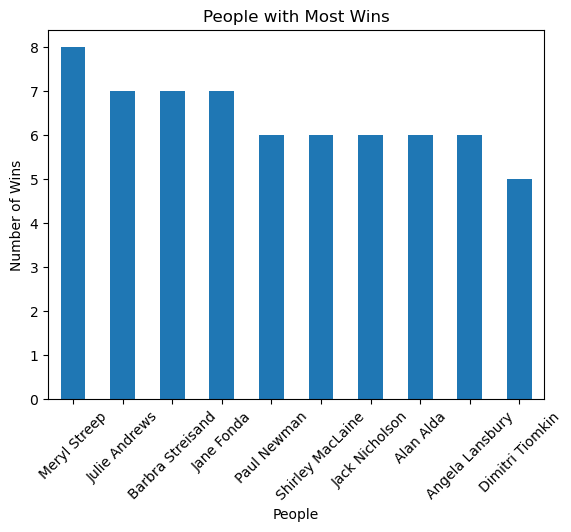

In [491]:
people_most_wins_plot = people_most_wins.plot(kind="bar", 
                                rot=45, 
                                xlabel="People",
                                ylabel="Number of Wins", 
                                title="People with Most Wins",
                            )


In [430]:
people_most_nominations = data_no_empty_titles[
    (data_no_empty_titles.nominee_type == "people")
    ].groupby("title").size().sort_values(ascending=False).head(10)

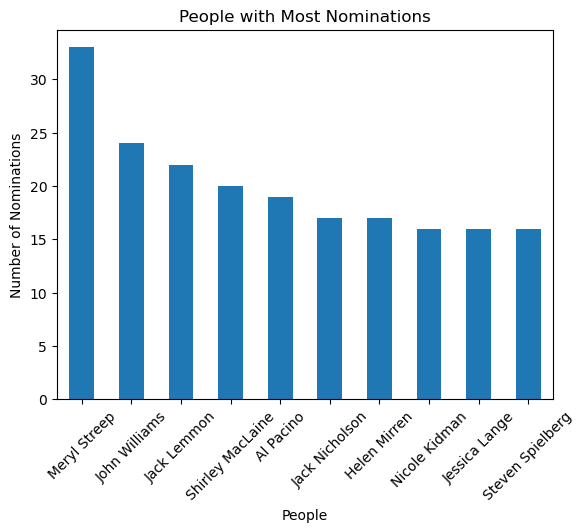

In [431]:
people_most_nominations_plot = people_most_nominations.plot(kind="bar", 
                                              rot=45, 
                                              xlabel="People", 
                                              ylabel="Number of Nominations", 
                                              title="People with Most Nominations"
                                             )

In [483]:
films_most_wins = data_no_empty_titles[
    (data_no_empty_titles.winner == True) & 
    (data_no_empty_titles.nominee_type == "film")
    ].groupby("title").size().sort_values(ascending=False).head(10)

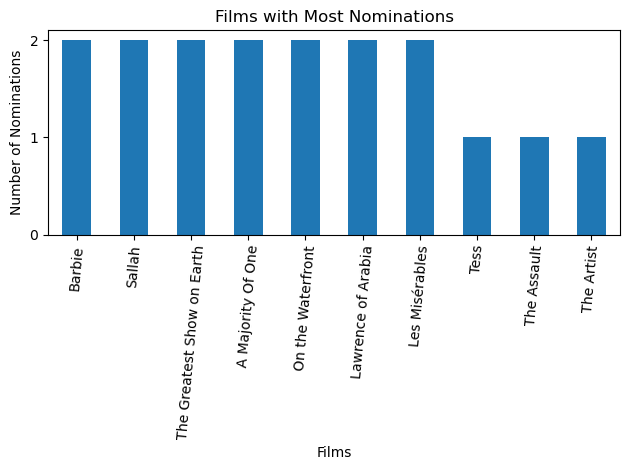

In [487]:
films_most_wins_plot = films_most_wins.plot(kind="bar", 
                                              rot=85, 
                                              xlabel="Films", 
                                              ylabel="Number of Nominations", 
                                              title="Films with Most Nominations",
                                             )

ax = plt.gca()
y_min, y_max = ax.get_ylim()
plt.yticks(range(int(y_min), int(y_max)+1))
plt.tight_layout()
plt.show()

In [466]:
films_most_nominations = data_no_empty_titles[
    (data_no_empty_titles.nominee_type == "film")
    ].groupby("title").size().sort_values(ascending=False).head(10)

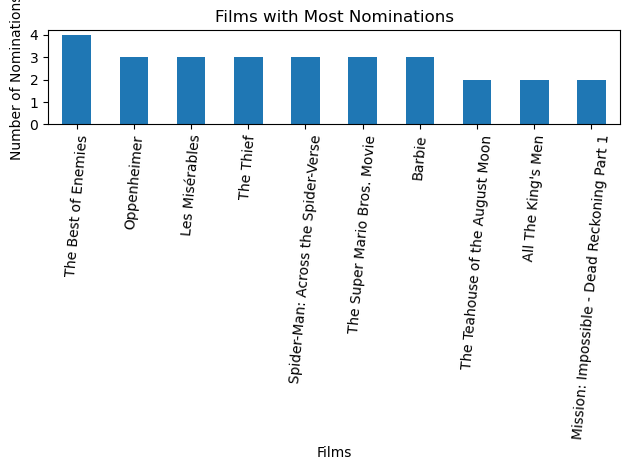

In [486]:
films_most_nominations_plot = films_most_nominations.plot(kind="bar", 
                                              rot=85, 
                                              xlabel="Films", 
                                              ylabel="Number of Nominations", 
                                              title="Films with Most Nominations"
                                             )

ax = plt.gca()
y_min, y_max = ax.get_ylim()
plt.yticks(range(int(y_min), int(y_max)+1))
plt.tight_layout()
plt.show()

In [492]:
tv_shows_most_nominations = data_no_empty_titles[
    (data_no_empty_titles.nominee_type == "tv-show")
    ].groupby("title").size().sort_values(ascending=False).head(10)

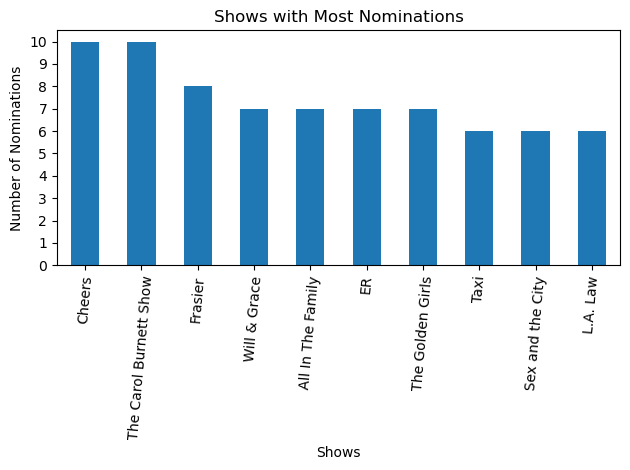

In [494]:
tv_shows_most_nominations_plot = tv_shows_most_nominations.plot(kind="bar", 
                                              rot=85, 
                                              xlabel="Shows", 
                                              ylabel="Number of Nominations", 
                                              title="Shows with Most Nominations"
                                             )

ax = plt.gca()
y_min, y_max = ax.get_ylim()
plt.yticks(range(int(y_min), int(y_max)+1))
plt.tight_layout()
plt.show()

In [495]:
tv_shows_most_wins = data_no_empty_titles[
    (data_no_empty_titles.nominee_type == "tv-show")
    & (data_no_empty_titles.winner == True)
    ].groupby("title").size().sort_values(ascending=False).head(10)

In [ ]:
tv_shows_most_wins_plot = tv_shows_most_wins.plot(kind="bar", 
                                              rot=85, 
                                              xlabel="Shows", 
                                              ylabel="Number of Nominations", 
                                              title="Shows with Most Nominations"
                                             )

ax = plt.gca()
y_min, y_max = ax.get_ylim()
plt.yticks(range(int(y_min), int(y_max)+1))
plt.tight_layout()
plt.show()